In [1]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
import time
import serial
import threading

## Loading in data

In [2]:
#Data comes from 4
df = pd.read_csv('tn_weather_csv.csv')
print(df.shape)
display(df.head())

(10481, 11)


,Date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition
0,4/19/2024,12:53:00 AM,68,59,73,SSW,8,0,28.95,0.0,Fair
1,4/19/2024,1:53:00 AM,67,59,76,S,5,0,28.94,0.0,Partly Cloudy
2,4/19/2024,2:53:00 AM,67,59,76,SSW,6,0,28.92,0.0,Fair
3,4/19/2024,3:53:00 AM,67,60,79,SW,7,0,28.91,0.0,Partly Cloudy
4,4/19/2024,4:53:00 AM,68,62,81,WSW,10,0,28.93,0.0,Mostly Cloudy


## Cleaning the data

In [3]:
df = df.drop(['Date','Time','Wind','Wind Speed (mph)','Wind Gust (mph)','Pressure (in)','Precip. (in)','Condition'], axis=1)
df.reset_index(inplace=True, drop=True)

print(df.shape)
display(df)

(10481, 3)


,Temperature (F),Dew Point (F),Humidity (%)
0,68,59,73
1,67,59,76
2,67,59,76
3,67,60,79
4,68,62,81
...,...,...,...
10476,75,42,31
10477,72,42,34
10478,71,41,34
10479,69,42,38


## Deciding on scores for probability of opening the window
- Dew point: https://www.weather.gov/arx/why_dewpoint_vs_humidity


In [4]:
cold_cold_outside_temp = 40
cold_outside_temp = 50
hot_outside_temp = 80
hot_hot_outside_temp = 95

def score_temp(row):
    temp = row['Temperature (F)']
    no_way_multiplier = 1
    score = 0
    if temp < cold_cold_outside_temp:
        no_way_multiplier = 0
    elif cold_cold_outside_temp <= temp < cold_outside_temp:
        score = -25
    elif cold_outside_temp <= temp < hot_outside_temp:
        score = -10
    elif hot_outside_temp <= temp < hot_hot_outside_temp:
        score = 0
    elif temp >= hot_hot_outside_temp:
        no_way_multiplier = 0
    t_score = ((temp + score) / 2) * no_way_multiplier
    return t_score

#less than or equal to 55: dry and comfortable
#between 55 and 65: becoming "sticky" with muggy evenings
#greater than or equal to 65: lots of moisture in the air, becoming oppressive
low_humidity = 30
high_humidity = 50
good_dew = 55
sticky_dew = 65
bad_dew = 80

def score_dew_point(row):
    dew_point = row['Dew Point (F)']
    no_way_multiplier = 1
    score = 0
    if dew_point <= good_dew:
        score = 0
    elif good_dew < dew_point < sticky_dew:
        score = -10
    elif dew_point < bad_dew:
        score = -25
    elif dew_point >= bad_dew:
        no_way_multiplier = 0
    d_score = ((dew_point + score) / 2) * no_way_multiplier
    return d_score

df['Likelihood of Opening Window'] = df.apply(score_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_dew_point, axis=1)
df['Likelihood of Opening Window'] = df['Likelihood of Opening Window'].clip(lower=0, upper=100)
display(df.head(10))

,Temperature (F),Dew Point (F),Humidity (%),Likelihood of Opening Window
0,68,59,73,53.5
1,67,59,76,53.0
2,67,59,76,53.0
3,67,60,79,53.5
4,68,62,81,55.0
5,67,63,87,55.0
6,67,64,90,55.5
7,66,64,93,55.0
8,66,64,93,55.0
9,66,65,96,48.0


In [5]:
idx_highest = df['Temperature (F)'].idxmax()
idx_lowest = df['Temperature (F)'].idxmin()
row_highest = df.loc[idx_highest]
row_lowest = df.loc[idx_lowest]
display(row_highest)
display(row_lowest)

Temperature (F)                 94.0
Dew Point (F)                   73.0
Humidity (%)                    51.0
Likelihood of Opening Window    71.0
Name: 6807, dtype: float64

Temperature (F)                  3.0
Dew Point (F)                    1.0
Humidity (%)                    91.0
Likelihood of Opening Window     0.5
Name: 2722, dtype: float64

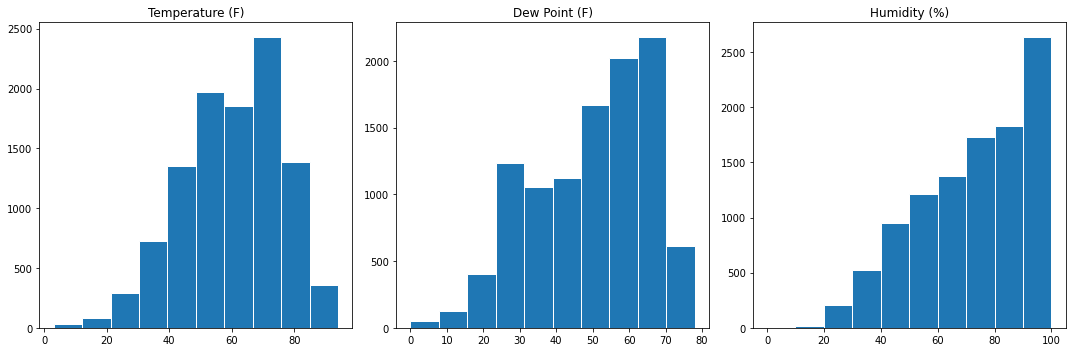

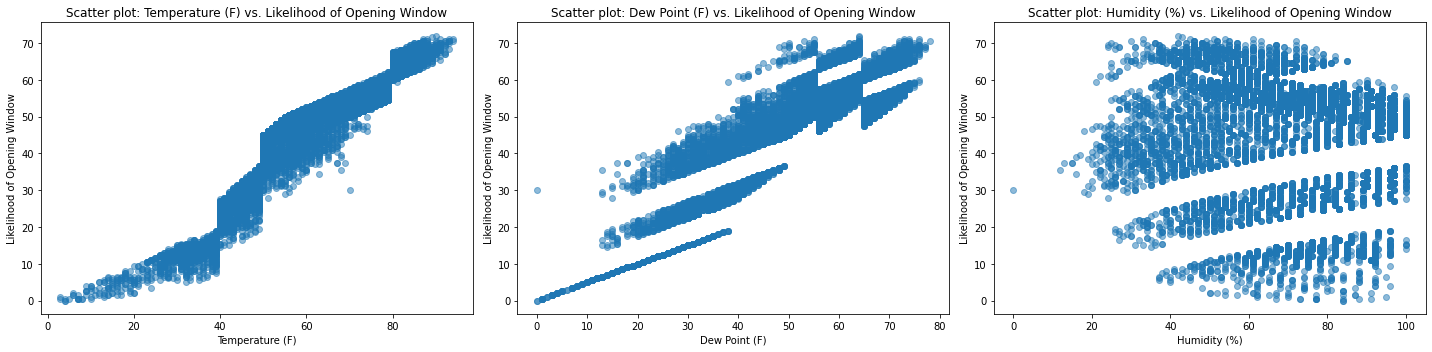

In [6]:
col = ['Temperature (F)', 'Dew Point (F)','Humidity (%)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Plot histograms
for i, column in enumerate(col):
    temp_df = pd.DataFrame(df[column], columns=[column])
    ax = axes[i]  
    ax.hist(temp_df[column], edgecolor='white')  
    ax.set_title(column)
plt.tight_layout()  

#Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, column in enumerate(col):
    ax = axes[i]
    ax.scatter(df[column], df['Likelihood of Opening Window'], alpha=0.5)
    ax.set_xlabel(column)
    ax.set_ylabel('Likelihood of Opening Window')
    ax.set_title(f'Scatter plot: {column} vs. Likelihood of Opening Window')

plt.tight_layout()
plt.show()

## Train and test model

In [7]:
data_df = df.drop('Likelihood of Opening Window', axis=1)
target_df = pd.DataFrame(df['Likelihood of Opening Window'], columns=['Likelihood of Opening Window'])

x_train, x_test, y_train, y_test = train_test_split(data_df, target_df, test_size=0.3, random_state=69)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7336, 3)
(3145, 3)
(7336, 1)
(3145, 1)


<Axes: >

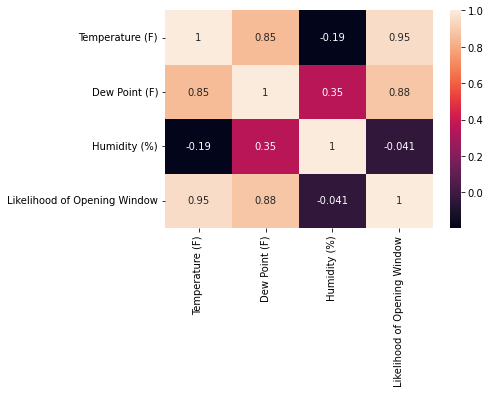

In [8]:
#Negative correlations (when one variable increases, the other variable tends to decrease)
sns.heatmap(pd.concat([x_train, y_train], axis=1).corr(), annot=True)

## Training model and results

In [9]:
#Create quadratic features
poly_features = PolynomialFeatures(degree=2)
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.fit_transform(x_test)

#Fit the quadratic regression model
lm = linear_model.LinearRegression()
lm = lm.fit(x_train_poly, y_train)
predictions_quad = lm.predict(x_train_poly)
y_train_pred_quad = pd.DataFrame(predictions_quad, columns=['Predicted Likelihood of Opening Window'])

#Mean Squared Error
mse_quad = mean_squared_error(y_train, y_train_pred_quad)
print('Mean squared error (Train) with quadratic model:', round(mse_quad, 4))

#Accuracy
score_quad = lm.score(x_train_poly, y_train)
print('Explained variance of the predictions (Train) with quadratic model:', score_quad)

Mean squared error (Train) with quadratic model: 13.0536
Explained variance of the predictions (Train) with quadratic model: 0.9478563147094303


In [10]:
#Predictions using quadratic model
predictions_quad_test = lm.predict(x_test_poly)
y_test_pred_quad = pd.DataFrame(predictions_quad_test, columns=['Predicted Likelihood of Opening Window'])

#Mean Squared Error for testing data with quadratic model
mse_quad_test = mean_squared_error(y_test, y_test_pred_quad)
print('Mean squared error (Testing) with quadratic model:', round(mse_quad_test, 4))

#Accuracy for testing data with quadratic model
score_quad_test = lm.score(x_test_poly, y_test)
print('Explained variance of the predictions (Testing) with quadratic model:', score_quad_test)


Mean squared error (Testing) with quadratic model: 13.0605
Explained variance of the predictions (Testing) with quadratic model: 0.9448424512207861


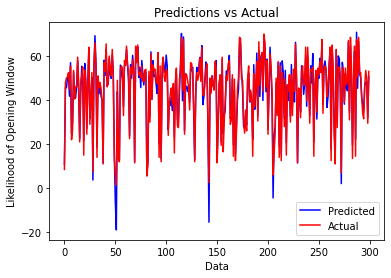

In [11]:
plt.plot(predictions_quad_test[:300], label='Predicted', color='blue')
plt.plot(y_test[:300].values, label='Actual', color='red')
plt.xlabel('Data')
plt.ylabel('Likelihood of Opening Window')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

## Comfy check and retrain model

Close window - too cold outside (cold_cold_outside_temp = 40)
- 65 inside, 38 F outside, 28 humidity = close window, uncomfy close completely
   
Open window - hot inside
- 70 inside, 60 outside, 60 humidity = open window 1/3, uncomfy open 2/3    

Close window - too hot outside (hot_hot_outside_temp = 95)
- 65 inside, 95 F outside, 52 humidity = open window, uncomfy close completely

In [14]:
import datetime

global_data = None
my_predict_percent = 0
my_likelihood = 0
my_time = 0.0


def retrain_model():
    global x_train, y_train
    new_data_df = new_data.drop(columns=['Likelihood of Opening Window'], axis=1)
    x_train = pd.concat([x_train, new_data_df])
    likelihood = new_data['Likelihood of Opening Window']

    #Close window - too cold outside (cold_cold_outside_temp = 40)
    #Close window - too hot outside (hot_hot_outside_temp = 95)
    #Ideal range of relative humidity for a home is between 30% and 50%, according to the EPA.
    if(temp <= cold_cold_outside_temp or temp >= hot_hot_outside_temp or inside_humidity < 30 or inside_humidity > 50):
        y_train = pd.concat([y_train, (new_data['Likelihood of Opening Window'] * 0)])
        likelihood *= 0 
    #Open window - hot inside
    elif(inside_temp > temp and abs(inside_temp-temp) == 10):
        y_train = pd.concat([y_train, (new_data['Likelihood of Opening Window'] * 1.5).clip(lower=0, upper=100)])
        likelihood *= 1.5
    #Open window - hot outside/cold inside?
    elif(inside_temp < temp and abs(inside_temp-temp) == 10):
        y_train = pd.concat([y_train, (new_data['Likelihood of Opening Window'] * 0.5).clip(lower=0, upper=100)])
        likelihood *= 0.5
    else:
        y_train = pd.concat([y_train, (new_data['Likelihood of Opening Window']).clip(lower=0, upper=100)])


    #Retraining the model
    global lm 
    poly_features = PolynomialFeatures(degree=2)
    x_train_poly = poly_features.fit_transform(x_train)
    lm = linear_model.LinearRegression()
    lm = lm.fit(x_train_poly, y_train)  # Retrain the model

    #new_data_poly = poly_features.transform(new_data.drop(columns=['Likelihood of Opening Window']))
    prediction = lm.predict(x_train_poly)
    #y_train.iloc[-1] = prediction[0].item()
    print("---------------")
    print("---------------")
    #print(f"New likelihood is {likelihood}.")
    print(f"New likelihood should be {likelihood[0]}.")
    print(f"New prediction is {prediction[0].item()}.")
    print("I retrained my model to better suit your preference!")
    
    #Sending prediction to window
    predict_percent = round(likelihood[0]/100.0, 1)
    predict_percent = 1 - predict_percent
    if(predict_percent < 0.0):
        predict_percent = 0.0
    elif(predict_percent > 1.0):
        predict_percent = 1.0

    print(f"Sending likelihood to serial (1 is close): {predict_percent}\n")
    ser_outside.write(f'{predict_percent:7.1f}'.encode('utf-8'))
    global my_predict_percent, my_time, my_likelihood
    my_likelihood = likelihood[0]
    my_predict_percent = predict_percent
    my_time = datetime.datetime.now()    
    print("---------------")
    print("---------------\n")


# Thread function to continuously read from serial port
def read_inside_serial(ser, lock):
    global global_data
    while True:
        with lock:
            if ser.in_waiting:
                data = ser.readline().decode('ascii').strip()
                if data == "button":
                    retrain_model()
                else:
                    global_data = data




ser_inside = serial.Serial(port='COM11', baudrate=4800)
ser_outside = serial.Serial(port='COM12', baudrate=4800)
print("Serial port opened")

minutes = 0
inside_temp = 0
outside_data_str = ''


# Create lock for serial access
serial_lock = threading.Lock()

# Create and start thread for reading serial
serial_thread = threading.Thread(target=read_inside_serial, args=(ser_inside, serial_lock), daemon=True)
serial_thread.start()

# Main program loop
while True:
    if global_data is not None:
        inside_data_str = global_data
        global_data = None
    else:
        inside_data_str = ''

    if ser_outside.inWaiting(): # only read if there is something waiting to be read
        outside_data_str = ser_outside.read(ser_outside.inWaiting()).decode('ascii') 
        #print("GOT outside: ", outside_data_str)
    
    #Once it has both inside and outside readings...
    if(outside_data_str != '' and inside_data_str != '' and inside_data_str != "button"):
        #Dissect inside data
        inside_data_str_float = inside_data_str
        #print("GOT inside: ", inside_data_str_float)
        inside_data_str_float = inside_data_str_float.split(',')
        inside_humidity = float(inside_data_str_float[0])
        inside_temp = (float(inside_data_str_float[1]) * 9/5) + 32
        inside_dew = inside_temp - ((100 - inside_humidity) / 5.0)
        print(f"--- Inside humidity: {inside_humidity} ---")
        print(f"--- Inside temp: {inside_temp} ---\n")

        #Dissect outside data
        outside_data_str_float = outside_data_str
        outside_data_str_float = outside_data_str_float.split('\n')[-2].split(',')
        humidity = float(outside_data_str_float[0])
        temp = (float(outside_data_str_float[1]) * 9/5) + 32
        dew = temp - ((100 - humidity) / 5.0)
        new_data = pd.DataFrame({
            'Temperature (F)': [temp],
            'Dew Point (F)': [dew],
            'Humidity (%)': [humidity],
        })
        print(f"--- Outside humidity: {humidity} ---")
        print(f"--- Outside temp: {temp} ---")
        print(f"--- Outside dew: {dew} ---\n")

        if(my_predict_percent != 0):
            print(f"I am {my_likelihood:.2f}% likely to open the window")
            new_data['Likelihood of Opening Window'] = my_likelihood
            predict_percent = my_predict_percent
            print(f"Percent sent to window: {predict_percent}")
        else:
            prediction = lm.predict(poly_features.transform(new_data))
            print(f"I am {prediction[0].item():.2f}% likely to open the window")
            predict_percent = round(prediction[0].item()/100.0, 1)
            predict_percent = 1 - predict_percent
            if(predict_percent < 0.0):
                predict_percent = 0.0
            elif(predict_percent > 1.0):
                predict_percent = 1.0
            print(f"Prediction percent for window = {predict_percent}")
            new_data['Likelihood of Opening Window'] = prediction[0].item()

        #Add new data to training - no retraining tho
        
        x_train = pd.concat([x_train, new_data.drop(columns=['Likelihood of Opening Window'])])
        y_train = pd.concat([y_train, (new_data['Likelihood of Opening Window']).clip(lower=0, upper=100)])
    
        now = datetime.datetime.now()   
        if (my_time != 0 and abs(my_time.second - now.second) >= 15) or (my_time == 0 and now.second % 15 == 0):
            #Send data to window
            print(f"SENDING likelihood to serial (1 is closed): {predict_percent}\n")
            ser_outside.write(f'{predict_percent:7.1f}'.encode('utf-8'))
            my_time = 0
            my_predict_percent = 0
    
    print("###############################")
    time.sleep(1)
    

Serial port opened
###############################
--- Inside humidity: 51.5 ---
--- Inside temp: 75.02 ---

--- Outside humidity: 52.7 ---
--- Outside temp: 74.84 ---
--- Outside dew: 65.38000000000001 ---

I am 74.53% likely to open the window
Prediction percent for window = 0.30000000000000004
###############################
--- Inside humidity: 51.5 ---
--- Inside temp: 75.02 ---

--- Outside humidity: 52.7 ---
--- Outside temp: 74.84 ---
--- Outside dew: 65.38000000000001 ---

I am 74.53% likely to open the window
Prediction percent for window = 0.30000000000000004
SENDING likelihood to serial (1 is closed): 0.30000000000000004

###############################
--- Inside humidity: 51.5 ---
--- Inside temp: 75.02 ---

--- Outside humidity: 52.7 ---
--- Outside temp: 74.84 ---
--- Outside dew: 65.38000000000001 ---

I am 74.53% likely to open the window
Prediction percent for window = 0.30000000000000004
###############################
--- Inside humidity: 51.5 ---
--- Inside temp: 